# Taller: Clasificación KNN y Análisis de Overfitting

- **Notebook:** Sesión 03: KNN y Análisis de Overfitting
- **Dataset:** Dataset Wine - Guía Educativa Completa
- **Profesor:** Marco Terán
- **Estudiante:** Edward Alejandro Rayo Cortés
- **Curso:** ST1631-ml-aplicado
- **Fecha:** 2025-10

---

## Objetivo del Taller

En este notebook aprenderemos conceptos fundamentales de Machine Learning:

1. **K-Nearest Neighbors (KNN)**: Un algoritmo de clasificación no paramétrico
2. **Overfitting y Underfitting**: Cómo identificar cuando un modelo es muy complejo o muy simple
3. **Evaluación de Complejidad**: Cómo encontrar el balance óptimo entre sesgo y varianza
4. **Métricas de Evaluación**: Accuracy, Precision, Recall y F1-Score

---

## 1. Configuración Inicial

Primero importamos todas las librerías necesarias para nuestro análisis.

In [4]:
# Configuración de visualización
%matplotlib inline

# Librerías básicas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylab as pl

# Scikit-learn: Dataset y particionamiento
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split

# Scikit-learn: Modelo KNN
from sklearn.neighbors import KNeighborsClassifier

# Scikit-learn: Métricas de evaluación
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

# Configurar semilla para reproducibilidad
RANDOM_SEED = 82
np.random.seed(RANDOM_SEED)

# Configurar estilo de gráficas
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Librerías importadas correctamente")

✓ Librerías importadas correctamente


### Funciones Auxiliares

Definimos funciones que nos ayudarán a visualizar nuestros datos y superficies de decisión.

In [2]:
# Función para visualizar un conjunto de datos en 2D
def plot_data(X, y, title="Datos"):
    """
    Visualiza datos en 2D con diferentes colores para cada clase
    
    Parámetros:
    -----------
    X : array-like, shape (n_samples, 2)
        Datos de entrada con 2 características
    y : array-like, shape (n_samples,)
        Etiquetas de clase
    title : str
        Título del gráfico
    """
    y_unique = np.unique(y)
    colors = pl.cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
    for this_y, color in zip(y_unique, colors):
        this_X = X[y == this_y]
        pl.scatter(this_X[:, 0], this_X[:, 1], c=[color],
                    alpha=0.6, edgecolor='k', s=50,
                    label=f"Clase {this_y}")
    pl.legend(loc="best")
    pl.title(title)
    pl.xlabel("Característica 1")
    pl.ylabel("Característica 2")
    
# Función para visualizar la superficie de decisión de un clasificador
def plot_decision_region(X, pred_fun, title="Superficie de Decisión"):
    """
    Visualiza la superficie de decisión de un clasificador
    
    Parámetros:
    -----------
    X : array-like, shape (n_samples, 2)
        Datos de entrada
    pred_fun : function
        Función de predicción del clasificador
    title : str
        Título del gráfico
    """
    min_x = np.min(X[:, 0])
    max_x = np.max(X[:, 0])
    min_y = np.min(X[:, 1])
    max_y = np.max(X[:, 1])
    
    # Añadir margen
    min_x = min_x - (max_x - min_x) * 0.1
    max_x = max_x + (max_x - min_x) * 0.1
    min_y = min_y - (max_y - min_y) * 0.1
    max_y = max_y + (max_y - min_y) * 0.1
    
    # Crear malla
    x_vals = np.linspace(min_x, max_x, 200)
    y_vals = np.linspace(min_y, max_y, 200)
    XX, YY = np.meshgrid(x_vals, y_vals)
    grid_r, grid_c = XX.shape
    ZZ = np.zeros((grid_r, grid_c))
    
    # Predecir para cada punto de la malla
    for i in range(grid_r):
        for j in range(grid_c):
            ZZ[i, j] = pred_fun(XX[i, j], YY[i, j])
    
    pl.contourf(XX, YY, ZZ, alpha=0.4, cmap=pl.cm.rainbow)
    pl.title(title)
    pl.xlabel("Característica 1")
    pl.ylabel("Característica 2")
    
def gen_pred_fun(clf):
    """
    Genera una función de predicción para un clasificador
    
    Parámetros:
    -----------
    clf : clasificador entrenado
        Modelo de scikit-learn
    
    Retorna:
    --------
    pred_fun : function
        Función que predice la clase de un punto (x1, x2)
    """
    def pred_fun(x1, x2):
        x = np.array([[x1, x2]])
        return clf.predict(x)[0]
    return pred_fun

print("✓ Funciones auxiliares definidas")

✓ Funciones auxiliares definidas


---
## 2. Carga y Exploración del Dataset Wine

### ¿Qué es el Dataset Wine?

El dataset Wine contiene los resultados de un análisis químico de vinos cultivados en la misma región de Italia pero derivados de tres cultivares diferentes. El análisis determinó las cantidades de 13 constituyentes encontrados en cada uno de los tres tipos de vinos.

**Características del dataset:**
- **Número de muestras**: 178
- **Número de características**: 13 (todas numéricas)
- **Número de clases**: 3 (tipos de vino)
- **Características incluyen**: Alcohol, Ácido málico, Ceniza, Alcalinidad de la ceniza, Magnesio, Fenoles totales, Flavonoides, Fenoles no flavonoides, Proantocianinas, Intensidad del color, Matiz, OD280/OD315 de vinos diluidos, Prolina

In [5]:
# Cargar el dataset Wine
wine_data = load_wine()

# Convertir a DataFrame para mejor visualización
X = wine_data.data
y = wine_data.target

# Crear DataFrame
wine_df = pd.DataFrame(X, columns=wine_data.feature_names)
wine_df['target'] = y

print("=" * 60)
print("INFORMACIÓN DEL DATASET WINE")
print("=" * 60)
print(f"\nDimensiones del dataset: {X.shape}")
print(f"  - Número de muestras: {X.shape[0]}")
print(f"  - Número de características: {X.shape[1]}")
print(f"\nNúmero de clases: {len(np.unique(y))}")
print(f"Clases: {np.unique(y)}")
print(f"\nNombres de las clases: {wine_data.target_names}")

INFORMACIÓN DEL DATASET WINE

Dimensiones del dataset: (178, 13)
  - Número de muestras: 178
  - Número de características: 13

Número de clases: 3
Clases: [0 1 2]

Nombres de las clases: ['class_0' 'class_1' 'class_2']


In [7]:
# Visualizar las primeras filas del dataset
print("\nPrimeras 5 muestras del dataset:\n")
display(wine_df.head())


Primeras 5 muestras del dataset:



,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


In [8]:
# Estadísticas descriptivas
print("\nEstadísticas descriptivas del dataset:\n")
display(wine_df.describe())


Estadísticas descriptivas del dataset:



,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258,0.938202
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474,0.775035
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000,0.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000,0.000000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000,1.000000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000,2.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000,2.000000



Distribución de clases en el dataset completo:
0    59
1    71
2    48
Name: count, dtype: int64


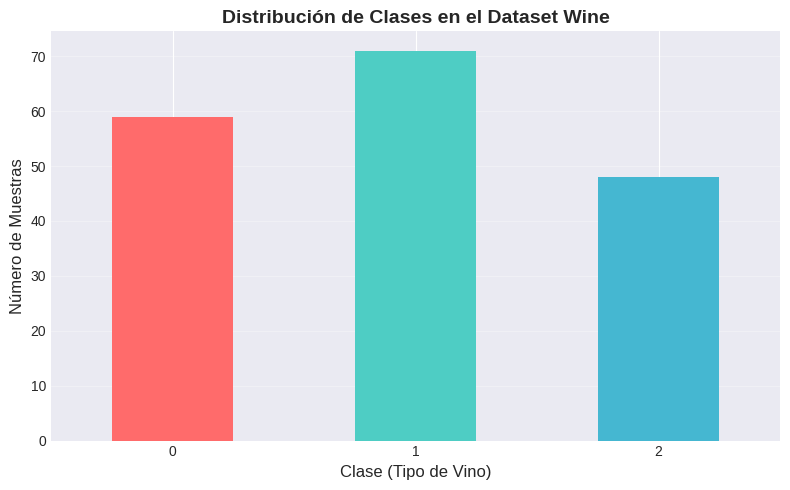


📊 Observación: Las clases no están perfectamente balanceadas.
   Por esto es importante usar estratificación al dividir los datos.


In [9]:
# Distribución de clases en el dataset completo
print("\nDistribución de clases en el dataset completo:")
print(pd.Series(y).value_counts().sort_index())

# Visualizar distribución
plt.figure(figsize=(8, 5))
pd.Series(y).value_counts().sort_index().plot(kind='bar', color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
plt.title('Distribución de Clases en el Dataset Wine', fontsize=14, fontweight='bold')
plt.xlabel('Clase (Tipo de Vino)', fontsize=12)
plt.ylabel('Número de Muestras', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n📊 Observación: Las clases no están perfectamente balanceadas.")
print("   Por esto es importante usar estratificación al dividir los datos.")

---
## 3. Partición Estratificada 70-30

### ¿Por qué es importante la estratificación?

Cuando dividimos nuestros datos en conjuntos de entrenamiento y prueba, queremos asegurarnos de que ambos conjuntos sean representativos del dataset original. La **estratificación** garantiza que la proporción de clases se mantenga en ambas particiones.

**Ventajas de la estratificación:**
1. Mantiene la distribución original de clases
2. Reduce el sesgo en la evaluación del modelo
3. Proporciona estimaciones más confiables del rendimiento

**División 70-30:**
- 70% de los datos para **entrenamiento** (aprender patrones)
- 30% de los datos para **prueba** (evaluar generalización)

In [10]:
# Realizar partición estratificada 70-30
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,           # 30% para prueba
    random_state=RANDOM_SEED, # Reproducibilidad
    stratify=y                # Mantener distribución de clases
)

print("=" * 60)
print("PARTICIÓN DE DATOS REALIZADA")
print("=" * 60)
print(f"\nConjunto de ENTRENAMIENTO:")
print(f"  - Número de muestras: {X_train.shape[0]} ({X_train.shape[0]/X.shape[0]*100:.1f}%)")
print(f"  - Número de características: {X_train.shape[1]}")

print(f"\nConjunto de PRUEBA:")
print(f"  - Número de muestras: {X_test.shape[0]} ({X_test.shape[0]/X.shape[0]*100:.1f}%)")
print(f"  - Número de características: {X_test.shape[1]}")

PARTICIÓN DE DATOS REALIZADA

Conjunto de ENTRENAMIENTO:
  - Número de muestras: 124 (69.7%)
  - Número de características: 13

Conjunto de PRUEBA:
  - Número de muestras: 54 (30.3%)
  - Número de características: 13


### Verificación de la Estratificación

Ahora vamos a verificar que la distribución de clases se mantuvo en ambas particiones.

In [15]:
# Calcular distribuciones
train_distribution = pd.Series(y_train).value_counts().sort_index()
test_distribution = pd.Series(y_test).value_counts().sort_index()
original_distribution = pd.Series(y).value_counts().sort_index()

# Crear DataFrame comparativo
distribution_df = pd.DataFrame({
    'Original': original_distribution,
    'Entrenamiento': train_distribution,
    'Prueba': test_distribution
})

print("\nDistribución de clases (número de muestras):")
display(distribution_df)

# Calcular proporciones
print("\nDistribución de clases (proporciones %):")
proportions_df = pd.DataFrame({
    'Original (%)': (original_distribution / len(y) * 100).round(2),
    'Entrenamiento (%)': (train_distribution / len(y_train) * 100).round(2),
    'Prueba (%)': (test_distribution / len(y_test) * 100).round(2)
})
display(proportions_df)


Distribución de clases (número de muestras):


,Original,Entrenamiento,Prueba
0,59,41,18
1,71,50,21
2,48,33,15



Distribución de clases (proporciones %):


,Original (%),Entrenamiento (%),Prueba (%)
0,33.15,33.06,33.33
1,39.89,40.32,38.89
2,26.97,26.61,27.78


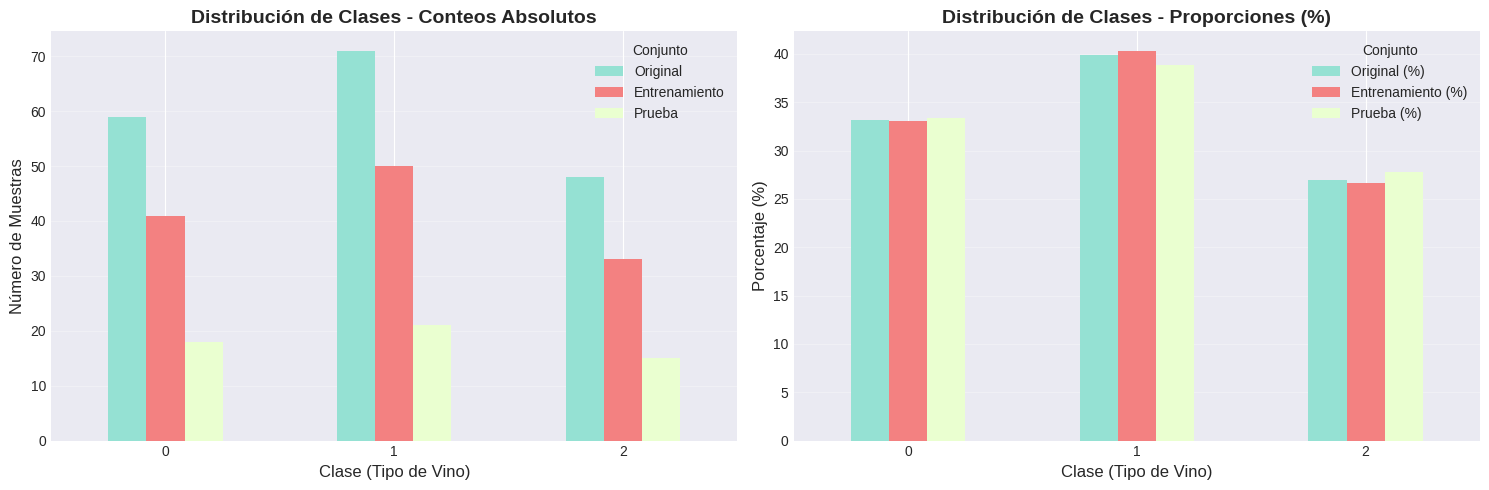


✓ Verificación completada: Las proporciones se mantienen aproximadamente iguales
  en los tres conjuntos, confirmando que la estratificación fue exitosa.


In [12]:
# Gráfica de barras comparativa
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Gráfica 1: Conteos absolutos
distribution_df.plot(kind='bar', ax=axes[0], color=['#95E1D3', '#F38181', '#EAFFD0'])
axes[0].set_title('Distribución de Clases - Conteos Absolutos', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Clase (Tipo de Vino)', fontsize=12)
axes[0].set_ylabel('Número de Muestras', fontsize=12)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)
axes[0].legend(title='Conjunto')
axes[0].grid(axis='y', alpha=0.3)

# Gráfica 2: Proporciones
proportions_df.plot(kind='bar', ax=axes[1], color=['#95E1D3', '#F38181', '#EAFFD0'])
axes[1].set_title('Distribución de Clases - Proporciones (%)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Clase (Tipo de Vino)', fontsize=12)
axes[1].set_ylabel('Porcentaje (%)', fontsize=12)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)
axes[1].legend(title='Conjunto')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Verificación completada: Las proporciones se mantienen aproximadamente iguales")
print("  en los tres conjuntos, confirmando que la estratificación fue exitosa.")

---
## 4. Explorando la Complejidad con KNN (Todas las Características)

### ¿Qué es K-Nearest Neighbors (KNN)?

KNN es un algoritmo de clasificación que predice la clase de una muestra basándose en las clases de sus **k vecinos más cercanos**.

**Concepto clave:**
- **k pequeño (ej. k=1)**: Modelo MUY COMPLEJO → Riesgo de **overfitting** (sobreajuste)
  - Aprende el ruido de los datos
  - Bajo error de entrenamiento, alto error de prueba
  
- **k grande (ej. k=100)**: Modelo MUY SIMPLE → Riesgo de **underfitting** (subajuste)
  - No captura patrones complejos
  - Alto error de entrenamiento y prueba

**Objetivo**: Encontrar el **k óptimo** que balancee complejidad y generalización.

In [27]:
# Definir rango de valores k a evaluar
k_values = list(range(1, 21))  # De 1 a 20
print(f"Valores de k a evaluar: {k_values}")
print(f"Total de modelos a entrenar: {len(k_values)}")

Valores de k a evaluar: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Total de modelos a entrenar: 20


In [28]:
# Listas para almacenar los errores
train_errors = []
test_errors = []
k_evals = {}

print("Entrenando modelos KNN con diferentes valores de k...\n")

# Entrenar un modelo KNN para cada valor de k
for k in k_values:
    # Crear modelo KNN
    knn = KNeighborsClassifier(n_neighbors=k)

    # Entrenar el modelo
    knn.fit(X_train, y_train)

    # Calcular accuracy
    train_accuracy = knn.score(X_train, y_train)
    test_accuracy = knn.score(X_test, y_test)

    # Calcular errores (error = 1 - accuracy)
    train_error = 1 - train_accuracy
    test_error = 1 - test_accuracy

    # Calcular gap (diferencia entre errores)
    gap = test_error - train_error

    # Clasificar el comportamiento del modelo
    if gap > 0.15:
        comportamiento = "Overfitting"
    elif gap < 0.05 and test_error < 0.25:
        comportamiento = "Óptimo"
    elif test_error > 0.30:
        comportamiento = "Underfitting"
    else:
        comportamiento = "Aceptable"

    # Guardar errores
    train_errors.append(train_error)
    test_errors.append(test_error)

    # Guardar todos los atributos
    k_evals[f"k={k}"] = {
        "Accuracy Train (%)": round(train_accuracy * 100, 2),
        "Accuracy Test (%)": round(test_accuracy * 100, 2),
        "Error Train (%)": round(train_error * 100, 2),
        "Error Test (%)": round(test_error * 100, 2),
        "Gap (%)": round(gap * 100, 2),
        "Comportamiento": comportamiento
    }

# Crear DataFrame transpuesto
kvals_df = pd.DataFrame(k_evals).T

print("📊 Tabla de Resultados por Valor de k (Todas las Características):")
print("=" * 100)
display(kvals_df)

print("\n✓ Entrenamiento completado para todos los valores de k")
print("\n📖 Interpretación de la tabla:")
print("  • Accuracy Train/Test: Porcentaje de predicciones correctas")
print("  • Error Train/Test: Porcentaje de predicciones incorrectas")
print("  • Gap: Diferencia entre error de prueba y entrenamiento")
print("    - Gap alto (>15%): Indica overfitting")
print("    - Gap bajo (<5%): Indica buen balance")
print("  • Comportamiento: Clasificación del modelo según sus métricas")

Entrenando modelos KNN con diferentes valores de k...

📊 Tabla de Resultados por Valor de k (Todas las Características):


,Accuracy Train (%),Accuracy Test (%),Error Train (%),Error Test (%),Gap (%),Comportamiento
k=1,100.0,74.07,0.0,25.93,25.93,Overfitting
k=2,86.29,66.67,13.71,33.33,19.62,Overfitting
k=3,86.29,70.37,13.71,29.63,15.92,Overfitting
k=4,80.65,70.37,19.35,29.63,10.27,Aceptable
k=5,79.03,68.52,20.97,31.48,10.51,Underfitting
k=6,76.61,66.67,23.39,33.33,9.95,Underfitting
k=7,77.42,70.37,22.58,29.63,7.05,Aceptable
k=8,77.42,66.67,22.58,33.33,10.75,Underfitting
k=9,79.03,70.37,20.97,29.63,8.66,Aceptable
k=10,78.23,70.37,21.77,29.63,7.86,Aceptable



✓ Entrenamiento completado para todos los valores de k

📖 Interpretación de la tabla:
  • Accuracy Train/Test: Porcentaje de predicciones correctas
  • Error Train/Test: Porcentaje de predicciones incorrectas
  • Gap: Diferencia entre error de prueba y entrenamiento
    - Gap alto (>15%): Indica overfitting
    - Gap bajo (<5%): Indica buen balance
  • Comportamiento: Clasificación del modelo según sus métricas


### Análisis Adicional: Destacando Mejores y Peores Modelos

La tabla anterior muestra todos los atributos calculados. Ahora vamos a identificar visualmente los mejores modelos:

**Atributos que se pueden agregar a la tabla:**

1. **Tiempo de entrenamiento**: Cuánto tardó en entrenar el modelo (útil para datasets grandes)
2. **Tiempo de predicción**: Cuánto tarda en hacer predicciones
3. **Número de errores absolutos**: Cantidad de muestras mal clasificadas
4. **Precisión por clase**: Accuracy individual para cada clase
5. **Recall por clase**: Sensibilidad para cada clase
6. **F1-Score**: Balance entre precisión y recall
7. **Matriz de confusión resumida**: Diagonal vs fuera de diagonal
8. **Complejidad del modelo**: Medida de cuán complejo es el modelo (inversa de k)
9. **Distancia promedio a vecinos**: Qué tan lejos están los vecinos en promedio
10. **Índice de confianza**: Basado en la consistencia de las predicciones

**Ventajas de tener más atributos:**
- Mejor comprensión del rendimiento del modelo
- Identificación de trade-offs (ej. accuracy vs. tiempo)
- Detección de problemas específicos por clase
- Toma de decisiones más informada sobre qué modelo usar

In [29]:
# Análisis visual: Resaltar mejores y peores modelos
print("🏆 TOP 5 MEJORES MODELOS (menor error de prueba):")
print("=" * 100)
top_5 = kvals_df.sort_values(by="Error Test (%)", ascending=True).head(5)
display(top_5)

print("\n⚠️ TOP 5 PEORES MODELOS (mayor error de prueba):")
print("=" * 100)
bottom_5 = kvals_df.sort_values(by="Error Test (%)", ascending=False).head(5)
display(bottom_5)

print("\n🎯 MODELOS ÓPTIMOS (Comportamiento = 'Óptimo'):")
print("=" * 100)
optimal_models = kvals_df[kvals_df["Comportamiento"] == "Óptimo"]
if len(optimal_models) > 0:
    display(optimal_models)
else:
    print("No se encontraron modelos clasificados como 'Óptimo'")

print("\n📊 ESTADÍSTICAS GENERALES:")
print("=" * 100)
stats_df = pd.DataFrame({
    "Métrica": ["Mejor Accuracy Test", "Peor Accuracy Test", "Promedio Accuracy Test", 
                "Menor Gap", "Mayor Gap", "Promedio Gap"],
    "Valor (%)": [
        kvals_df["Accuracy Test (%)"].max(),
        kvals_df["Accuracy Test (%)"].min(),
        kvals_df["Accuracy Test (%)"].mean().round(2),
        kvals_df["Gap (%)"].min(),
        kvals_df["Gap (%)"].max(),
        kvals_df["Gap (%)"].mean().round(2)
    ]
})
display(stats_df)

🏆 TOP 5 MEJORES MODELOS (menor error de prueba):


,Accuracy Train (%),Accuracy Test (%),Error Train (%),Error Test (%),Gap (%),Comportamiento
k=11,76.61,75.93,23.39,24.07,0.69,Óptimo
k=1,100.0,74.07,0.0,25.93,25.93,Overfitting
k=18,75.81,74.07,24.19,25.93,1.73,Aceptable
k=17,77.42,74.07,22.58,25.93,3.35,Aceptable
k=16,75.81,74.07,24.19,25.93,1.73,Aceptable



⚠️ TOP 5 PEORES MODELOS (mayor error de prueba):


,Accuracy Train (%),Accuracy Test (%),Error Train (%),Error Test (%),Gap (%),Comportamiento
k=6,76.61,66.67,23.39,33.33,9.95,Underfitting
k=8,77.42,66.67,22.58,33.33,10.75,Underfitting
k=2,86.29,66.67,13.71,33.33,19.62,Overfitting
k=5,79.03,68.52,20.97,31.48,10.51,Underfitting
k=15,76.61,68.52,23.39,31.48,8.09,Underfitting



🎯 MODELOS ÓPTIMOS (Comportamiento = 'Óptimo'):


,Accuracy Train (%),Accuracy Test (%),Error Train (%),Error Test (%),Gap (%),Comportamiento
k=11,76.61,75.93,23.39,24.07,0.69,Óptimo



📊 ESTADÍSTICAS GENERALES:


,Métrica,Valor (%)
0,Mejor Accuracy Test,75.93
1,Peor Accuracy Test,66.67
2,Promedio Accuracy Test,70.83
3,Menor Gap,0.69
4,Mayor Gap,25.93
5,Promedio Gap,8.08


### Visualización de las Curvas de Error

Esta gráfica es fundamental para entender el **trade-off entre sesgo y varianza**:

- **Error de entrenamiento** (azul): Qué tan bien el modelo se ajusta a los datos de entrenamiento
- **Error de prueba/generalización** (rojo): Qué tan bien el modelo predice datos nunca vistos

**Interpretación:**
- Si ambas curvas están muy separadas → **Overfitting**
- Si ambas curvas tienen error alto → **Underfitting**
- El **punto óptimo** está donde el error de prueba es mínimo

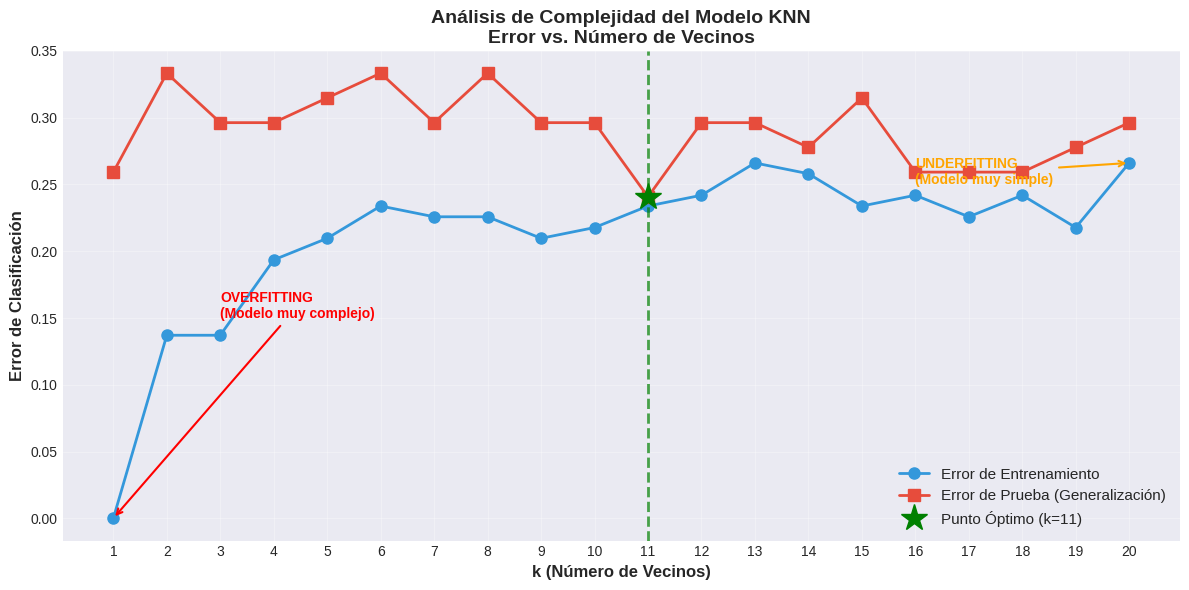


RESULTADOS DEL ANÁLISIS DE COMPLEJIDAD

Valor óptimo de k: 11
Error mínimo de prueba: 0.2407 (24.07%)
Error de entrenamiento con k=11: 0.2339 (23.39%)

Accuracy de prueba con k óptimo: 75.93%


In [30]:
# Graficar curvas de error
plt.figure(figsize=(12, 6))

plt.plot(k_values, train_errors, 'o-', linewidth=2, markersize=8, 
         label='Error de Entrenamiento', color='#3498db')
plt.plot(k_values, test_errors, 's-', linewidth=2, markersize=8, 
         label='Error de Prueba (Generalización)', color='#e74c3c')

# Encontrar k óptimo (menor error de prueba)
optimal_k = k_values[np.argmin(test_errors)]
min_test_error = min(test_errors)

# Marcar punto óptimo
plt.axvline(x=optimal_k, color='green', linestyle='--', linewidth=2, alpha=0.7)
plt.plot(optimal_k, min_test_error, 'g*', markersize=20, 
         label=f'Punto Óptimo (k={optimal_k})', zorder=5)

plt.xlabel('k (Número de Vecinos)', fontsize=12, fontweight='bold')
plt.ylabel('Error de Clasificación', fontsize=12, fontweight='bold')
plt.title('Análisis de Complejidad del Modelo KNN\nError vs. Número de Vecinos', 
          fontsize=14, fontweight='bold')
plt.xticks(k_values)
plt.legend(fontsize=11, loc='best')
plt.grid(True, alpha=0.3)

# Añadir anotaciones
plt.annotate('OVERFITTING\n(Modelo muy complejo)', 
             xy=(1, train_errors[0]), xytext=(3, 0.15),
             arrowprops=dict(arrowstyle='->', color='red', lw=1.5),
             fontsize=10, color='red', fontweight='bold')

plt.annotate('UNDERFITTING\n(Modelo muy simple)', 
             xy=(20, train_errors[-1]), xytext=(16, 0.25),
             arrowprops=dict(arrowstyle='->', color='orange', lw=1.5),
             fontsize=10, color='orange', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("RESULTADOS DEL ANÁLISIS DE COMPLEJIDAD")
print("="*60)
print(f"\nValor óptimo de k: {optimal_k}")
print(f"Error mínimo de prueba: {min_test_error:.4f} ({min_test_error*100:.2f}%)")
print(f"Error de entrenamiento con k={optimal_k}: {train_errors[optimal_k-1]:.4f} ({train_errors[optimal_k-1]*100:.2f}%)")
print(f"\nAccuracy de prueba con k óptimo: {(1-min_test_error)*100:.2f}%")

---
## 5. Análisis con Dos Características: Proline vs Flavonoids

### ¿Por qué analizar solo 2 características?

Cuando trabajamos con solo 2 características podemos:
1. **Visualizar** la superficie de decisión del clasificador
2. **Entender intuitivamente** cómo el modelo separa las clases
3. **Observar** el efecto del parámetro k en la complejidad de la frontera de decisión

**Características seleccionadas:**
- **Flavonoids**: Compuestos fenólicos que contribuyen al sabor y color
- **Proline**: Aminoácido presente en el vino

In [32]:
# Obtener índices de las características Flavonoids y Proline
feature_names = wine_data.feature_names
print("Características disponibles:")
for i, name in enumerate(feature_names):
    print(f"{i}: {name}")

# Encontrar índices
flavonoids_idx = feature_names.index('flavanoids')
proline_idx = feature_names.index('proline')

print(f"\nÍndice de Flavonoids: {flavonoids_idx}")
print(f"Índice de Proline: {proline_idx}")

Características disponibles:
0: alcohol
1: malic_acid
2: ash
3: alcalinity_of_ash
4: magnesium
5: total_phenols
6: flavanoids
7: nonflavanoid_phenols
8: proanthocyanins
9: color_intensity
10: hue
11: od280/od315_of_diluted_wines
12: proline

Índice de Flavonoids: 6
Índice de Proline: 12


In [33]:
# Extraer solo las características Flavonoids y Proline
# Nota: Usamos el orden [Proline, Flavonoids] para que Proline esté en el eje X
X_2d = X[:, [proline_idx, flavonoids_idx]]

# Realizar partición estratificada 70-30 con estas características
X_train_2d, X_test_2d, y_train_2d, y_test_2d = train_test_split(
    X_2d, y,
    test_size=0.3,
    random_state=RANDOM_SEED,
    stratify=y
)

print(f"\nDimensiones del nuevo conjunto de datos:")
print(f"  - X_train_2d: {X_train_2d.shape}")
print(f"  - X_test_2d: {X_test_2d.shape}")


Dimensiones del nuevo conjunto de datos:
  - X_train_2d: (124, 2)
  - X_test_2d: (54, 2)


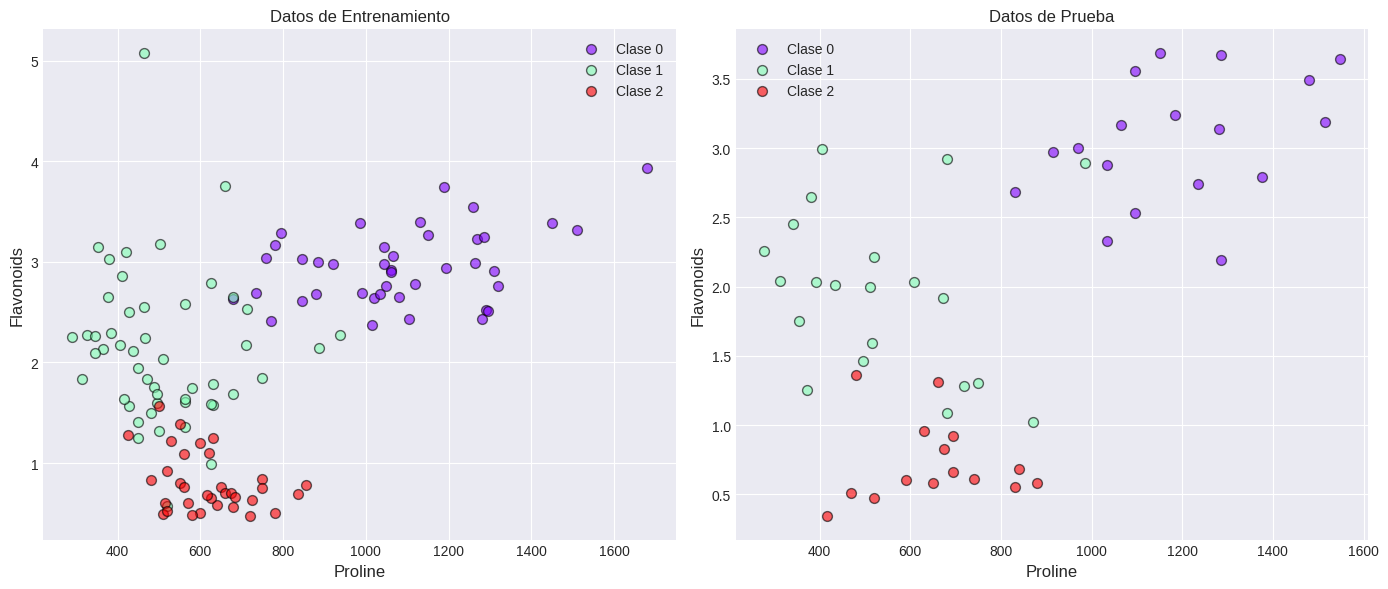


📊 Observación: Podemos ver que hay cierta separabilidad entre las clases,
   aunque hay algunas regiones donde las clases se superponen.


In [34]:
# Visualizar los datos en 2D
plt.figure(figsize=(14, 6))

# Subplot 1: Datos de entrenamiento
plt.subplot(1, 2, 1)
plot_data(X_train_2d, y_train_2d, title='Datos de Entrenamiento')
plt.xlabel('Proline', fontsize=12)
plt.ylabel('Flavonoids', fontsize=12)

# Subplot 2: Datos de prueba
plt.subplot(1, 2, 2)
plot_data(X_test_2d, y_test_2d, title='Datos de Prueba')
plt.xlabel('Proline', fontsize=12)
plt.ylabel('Flavonoids', fontsize=12)

plt.tight_layout()
plt.show()

print("\n📊 Observación: Podemos ver que hay cierta separabilidad entre las clases,")
print("   aunque hay algunas regiones donde las clases se superponen.")

### Evaluación de Complejidad con 2 Características

Repetimos el análisis de complejidad pero ahora solo con Proline y Flavonoids.

In [35]:
# Listas para almacenar los errores con 2 características
train_errors_2d = []
test_errors_2d = []
models_2d = {}  # Diccionario para guardar los modelos entrenados
k_evals_2d = {}

print("Entrenando modelos KNN con Proline vs Flavonoids...\n")

for k in k_values:
    # Crear y entrenar modelo
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_2d, y_train_2d)

    # Calcular accuracy
    train_accuracy = knn.score(X_train_2d, y_train_2d)
    test_accuracy = knn.score(X_test_2d, y_test_2d)

    # Calcular errores
    train_error = 1 - train_accuracy
    test_error = 1 - test_accuracy

    # Calcular gap
    gap = test_error - train_error

    # Clasificar el comportamiento del modelo
    if gap > 0.20:
        comportamiento = "Overfitting Alto"
    elif gap > 0.10:
        comportamiento = "Overfitting"
    elif gap < 0.05 and test_error < 0.30:
        comportamiento = "Óptimo"
    elif test_error > 0.35:
        comportamiento = "Underfitting"
    else:
        comportamiento = "Aceptable"

    # Guardar
    train_errors_2d.append(train_error)
    test_errors_2d.append(test_error)
    models_2d[k] = knn

    # Guardar todos los atributos
    k_evals_2d[f"k={k}"] = {
        "Accuracy Train (%)": round(train_accuracy * 100, 2),
        "Accuracy Test (%)": round(test_accuracy * 100, 2),
        "Error Train (%)": round(train_error * 100, 2),
        "Error Test (%)": round(test_error * 100, 2),
        "Gap (%)": round(gap * 100, 2),
        "Comportamiento": comportamiento
    }

# Crear DataFrame transpuesto
kvals_2d_df = pd.DataFrame(k_evals_2d).T

print("📊 Tabla de Resultados por Valor de k (Proline vs Flavonoids):")
print("=" * 100)
display(kvals_2d_df)

print("\n✓ Entrenamiento completado")
print("\n📖 Interpretación de la tabla:")
print("  • Accuracy Train/Test: Porcentaje de predicciones correctas")
print("  • Error Train/Test: Porcentaje de predicciones incorrectas")
print("  • Gap: Diferencia entre error de prueba y entrenamiento")
print("    - Gap muy alto (>20%): Overfitting severo")
print("    - Gap alto (10-20%): Overfitting moderado")
print("    - Gap bajo (<5%): Buen balance entre sesgo y varianza")
print("  • Comportamiento: Clasificación automática del modelo")

Entrenando modelos KNN con Proline vs Flavonoids...

📊 Tabla de Resultados por Valor de k (Proline vs Flavonoids):


,Accuracy Train (%),Accuracy Test (%),Error Train (%),Error Test (%),Gap (%),Comportamiento
k=1,100.0,70.37,0.0,29.63,29.63,Overfitting Alto
k=2,82.26,72.22,17.74,27.78,10.04,Overfitting
k=3,83.87,68.52,16.13,31.48,15.35,Overfitting
k=4,81.45,72.22,18.55,27.78,9.23,Aceptable
k=5,78.23,68.52,21.77,31.48,9.71,Aceptable
k=6,77.42,62.96,22.58,37.04,14.46,Overfitting
k=7,80.65,66.67,19.35,33.33,13.98,Overfitting
k=8,79.03,64.81,20.97,35.19,14.22,Overfitting
k=9,77.42,64.81,22.58,35.19,12.6,Overfitting
k=10,81.45,68.52,18.55,31.48,12.93,Overfitting



✓ Entrenamiento completado

📖 Interpretación de la tabla:
  • Accuracy Train/Test: Porcentaje de predicciones correctas
  • Error Train/Test: Porcentaje de predicciones incorrectas
  • Gap: Diferencia entre error de prueba y entrenamiento
    - Gap muy alto (>20%): Overfitting severo
    - Gap alto (10-20%): Overfitting moderado
    - Gap bajo (<5%): Buen balance entre sesgo y varianza
  • Comportamiento: Clasificación automática del modelo


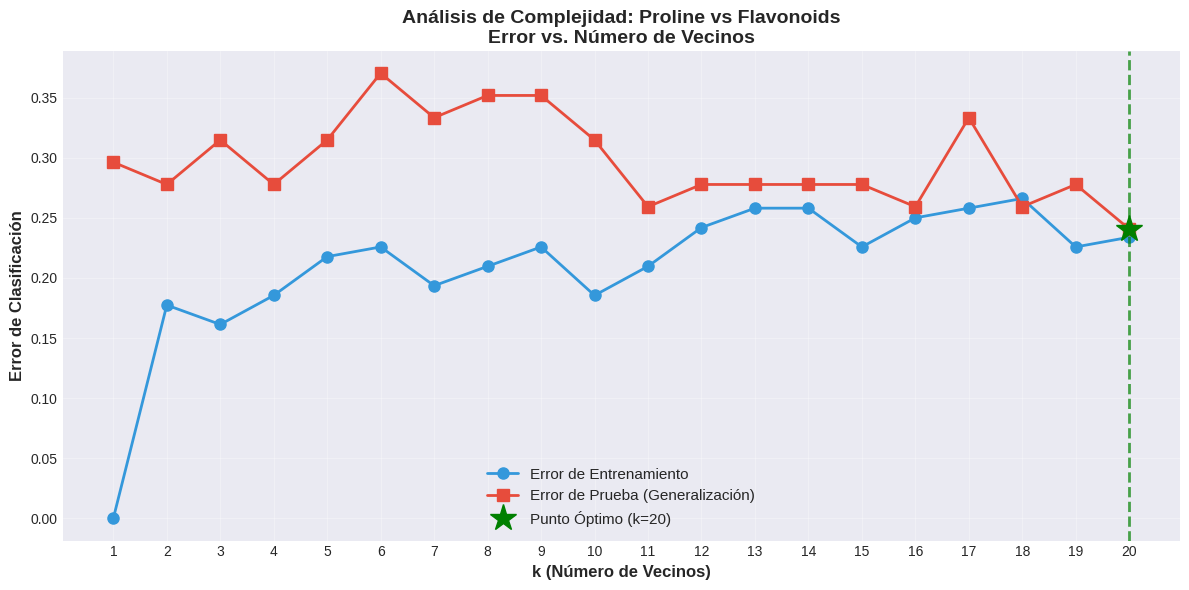


RESULTADOS: Proline vs Flavonoids

Valor óptimo de k: 20
Error mínimo de prueba: 0.2407 (24.07%)
Accuracy de prueba con k óptimo: 75.93%


In [36]:
# Graficar curvas de error para 2D
plt.figure(figsize=(12, 6))

plt.plot(k_values, train_errors_2d, 'o-', linewidth=2, markersize=8, 
         label='Error de Entrenamiento', color='#3498db')
plt.plot(k_values, test_errors_2d, 's-', linewidth=2, markersize=8, 
         label='Error de Prueba (Generalización)', color='#e74c3c')

# Encontrar k óptimo
optimal_k_2d = k_values[np.argmin(test_errors_2d)]
min_test_error_2d = min(test_errors_2d)

# Marcar punto óptimo
plt.axvline(x=optimal_k_2d, color='green', linestyle='--', linewidth=2, alpha=0.7)
plt.plot(optimal_k_2d, min_test_error_2d, 'g*', markersize=20, 
         label=f'Punto Óptimo (k={optimal_k_2d})', zorder=5)

plt.xlabel('k (Número de Vecinos)', fontsize=12, fontweight='bold')
plt.ylabel('Error de Clasificación', fontsize=12, fontweight='bold')
plt.title('Análisis de Complejidad: Proline vs Flavonoids\nError vs. Número de Vecinos', 
          fontsize=14, fontweight='bold')
plt.xticks(k_values)
plt.legend(fontsize=11, loc='best')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("RESULTADOS: Proline vs Flavonoids")
print("="*60)
print(f"\nValor óptimo de k: {optimal_k_2d}")
print(f"Error mínimo de prueba: {min_test_error_2d:.4f} ({min_test_error_2d*100:.2f}%)")
print(f"Accuracy de prueba con k óptimo: {(1-min_test_error_2d)*100:.2f}%")

In [37]:
# Análisis visual: Resaltar mejores modelos para 2D
print("🏆 TOP 5 MEJORES MODELOS - Proline vs Flavonoids (menor error de prueba):")
print("=" * 100)
top_5_2d = kvals_2d_df.sort_values(by="Error Test (%)", ascending=True).head(5)
display(top_5_2d)

print("\n⚠️ TOP 5 PEORES MODELOS - Proline vs Flavonoids (mayor error de prueba):")
print("=" * 100)
bottom_5_2d = kvals_2d_df.sort_values(by="Error Test (%)", ascending=False).head(5)
display(bottom_5_2d)

print("\n🎯 MODELOS ÓPTIMOS - Proline vs Flavonoids:")
print("=" * 100)
optimal_models_2d = kvals_2d_df[kvals_2d_df["Comportamiento"] == "Óptimo"]
if len(optimal_models_2d) > 0:
    display(optimal_models_2d)
else:
    print("No se encontraron modelos clasificados como 'Óptimo'")
    print("Mostrando modelos 'Aceptables':")
    acceptable = kvals_2d_df[kvals_2d_df["Comportamiento"] == "Aceptable"]
    if len(acceptable) > 0:
        display(acceptable)

print("\n📊 ESTADÍSTICAS GENERALES - Proline vs Flavonoids:")
print("=" * 100)
stats_2d_df = pd.DataFrame({
    "Métrica": ["Mejor Accuracy Test", "Peor Accuracy Test", "Promedio Accuracy Test", 
                "Menor Gap", "Mayor Gap", "Promedio Gap"],
    "Valor (%)": [
        kvals_2d_df["Accuracy Test (%)"].max(),
        kvals_2d_df["Accuracy Test (%)"].min(),
        kvals_2d_df["Accuracy Test (%)"].mean().round(2),
        kvals_2d_df["Gap (%)"].min(),
        kvals_2d_df["Gap (%)"].max(),
        kvals_2d_df["Gap (%)"].mean().round(2)
    ]
})
display(stats_2d_df)

# Comparación entre usar todas las características vs solo 2
print("\n🔍 COMPARACIÓN: Todas las Características vs Proline-Flavonoids:")
print("=" * 100)
comparison_df = pd.DataFrame({
    "Dataset": ["Todas las características (13)", "Proline vs Flavonoids (2)"],
    "Mejor Accuracy Test (%)": [
        kvals_df["Accuracy Test (%)"].max(),
        kvals_2d_df["Accuracy Test (%)"].max()
    ],
    "k óptimo": [
        kvals_df.sort_values(by="Error Test (%)", ascending=True).index[0],
        kvals_2d_df.sort_values(by="Error Test (%)", ascending=True).index[0]
    ],
    "Gap promedio (%)": [
        kvals_df["Gap (%)"].mean().round(2),
        kvals_2d_df["Gap (%)"].mean().round(2)
    ]
})
display(comparison_df)

print("\n💡 Observación:")
print("  • Con más características generalmente obtenemos mejor accuracy")
print("  • Con menos características el modelo es más simple pero puede perder información")
print("  • El gap nos indica qué tan bien generaliza el modelo")

🏆 TOP 5 MEJORES MODELOS - Proline vs Flavonoids (menor error de prueba):


,Accuracy Train (%),Accuracy Test (%),Error Train (%),Error Test (%),Gap (%),Comportamiento
k=20,76.61,75.93,23.39,24.07,0.69,Óptimo
k=18,73.39,74.07,26.61,25.93,-0.69,Óptimo
k=16,75.0,74.07,25.0,25.93,0.93,Óptimo
k=11,79.03,74.07,20.97,25.93,4.96,Óptimo
k=2,82.26,72.22,17.74,27.78,10.04,Overfitting



⚠️ TOP 5 PEORES MODELOS - Proline vs Flavonoids (mayor error de prueba):


,Accuracy Train (%),Accuracy Test (%),Error Train (%),Error Test (%),Gap (%),Comportamiento
k=6,77.42,62.96,22.58,37.04,14.46,Overfitting
k=9,77.42,64.81,22.58,35.19,12.6,Overfitting
k=8,79.03,64.81,20.97,35.19,14.22,Overfitting
k=7,80.65,66.67,19.35,33.33,13.98,Overfitting
k=17,74.19,66.67,25.81,33.33,7.53,Aceptable



🎯 MODELOS ÓPTIMOS - Proline vs Flavonoids:


,Accuracy Train (%),Accuracy Test (%),Error Train (%),Error Test (%),Gap (%),Comportamiento
k=11,79.03,74.07,20.97,25.93,4.96,Óptimo
k=12,75.81,72.22,24.19,27.78,3.58,Óptimo
k=13,74.19,72.22,25.81,27.78,1.97,Óptimo
k=14,74.19,72.22,25.81,27.78,1.97,Óptimo
k=16,75.0,74.07,25.0,25.93,0.93,Óptimo
k=18,73.39,74.07,26.61,25.93,-0.69,Óptimo
k=20,76.61,75.93,23.39,24.07,0.69,Óptimo



📊 ESTADÍSTICAS GENERALES - Proline vs Flavonoids:


,Métrica,Valor (%)
0,Mejor Accuracy Test,75.93
1,Peor Accuracy Test,62.96
2,Promedio Accuracy Test,70.28
3,Menor Gap,-0.69
4,Mayor Gap,29.63
5,Promedio Gap,8.67



🔍 COMPARACIÓN: Todas las Características vs Proline-Flavonoids:


,Dataset,Mejor Accuracy Test (%),k óptimo,Gap promedio (%)
0,Todas las características (13),75.93,k=11,8.08
1,Proline vs Flavonoids (2),75.93,k=20,8.67



💡 Observación:
  • Con más características generalmente obtenemos mejor accuracy
  • Con menos características el modelo es más simple pero puede perder información
  • El gap nos indica qué tan bien generaliza el modelo


---
## 6. Visualización de la Superficie de Decisión

La superficie de decisión muestra cómo el clasificador divide el espacio de características en regiones, una para cada clase.

**Interpretación:**
- Cada color de fondo representa la predicción del modelo para esa región
- Los puntos son las muestras reales del conjunto de prueba
- Las fronteras entre colores son las **fronteras de decisión**

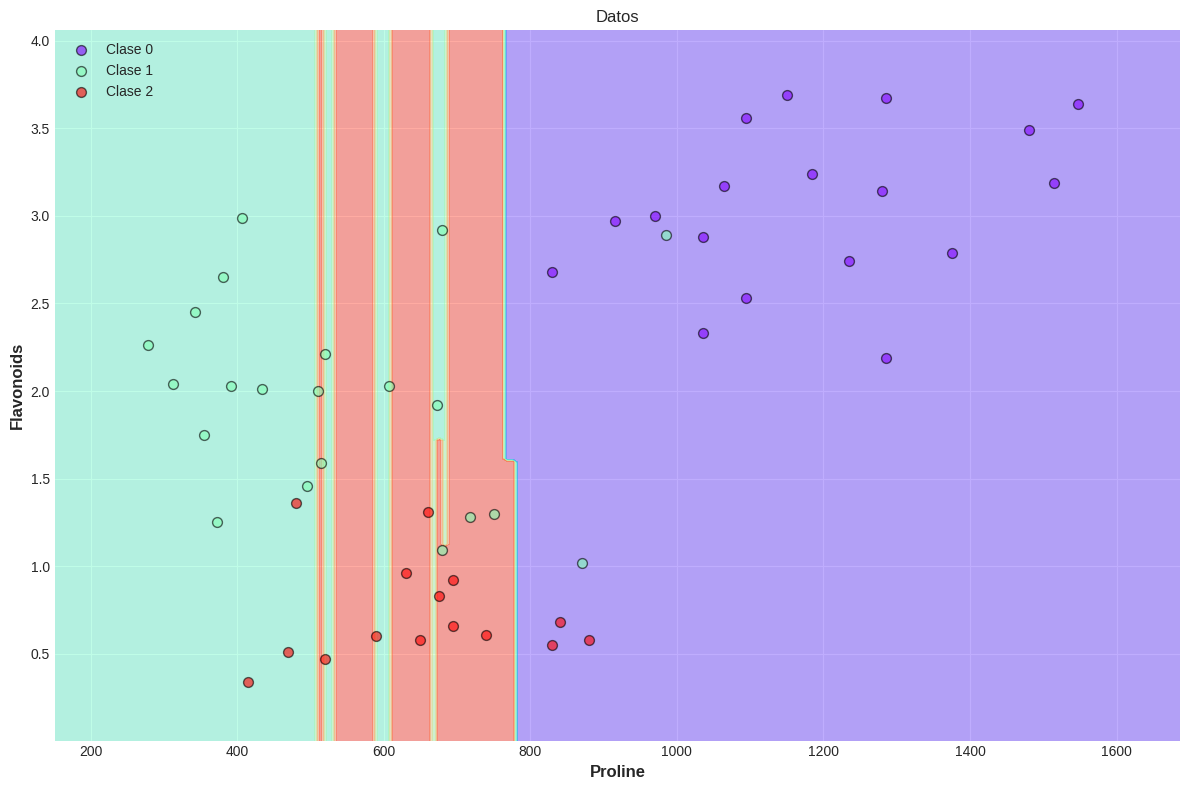


Modelo KNN con k=20 aplicado al conjunto de prueba
Accuracy: 75.93%


In [38]:
# Visualizar superficie de decisión con el k óptimo
optimal_model = models_2d[optimal_k_2d]

plt.figure(figsize=(12, 8))
plot_decision_region(X_test_2d, gen_pred_fun(optimal_model),
                     title=f'Superficie de Decisión KNN (k={optimal_k_2d}) - Conjunto de Prueba')
plot_data(X_test_2d, y_test_2d)
plt.xlabel('Proline', fontsize=12, fontweight='bold')
plt.ylabel('Flavonoids', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\nModelo KNN con k={optimal_k_2d} aplicado al conjunto de prueba")
print(f"Accuracy: {(1-min_test_error_2d)*100:.2f}%")

### Comparación Visual: Diferentes Valores de k

Veamos cómo cambia la superficie de decisión con diferentes valores de k:

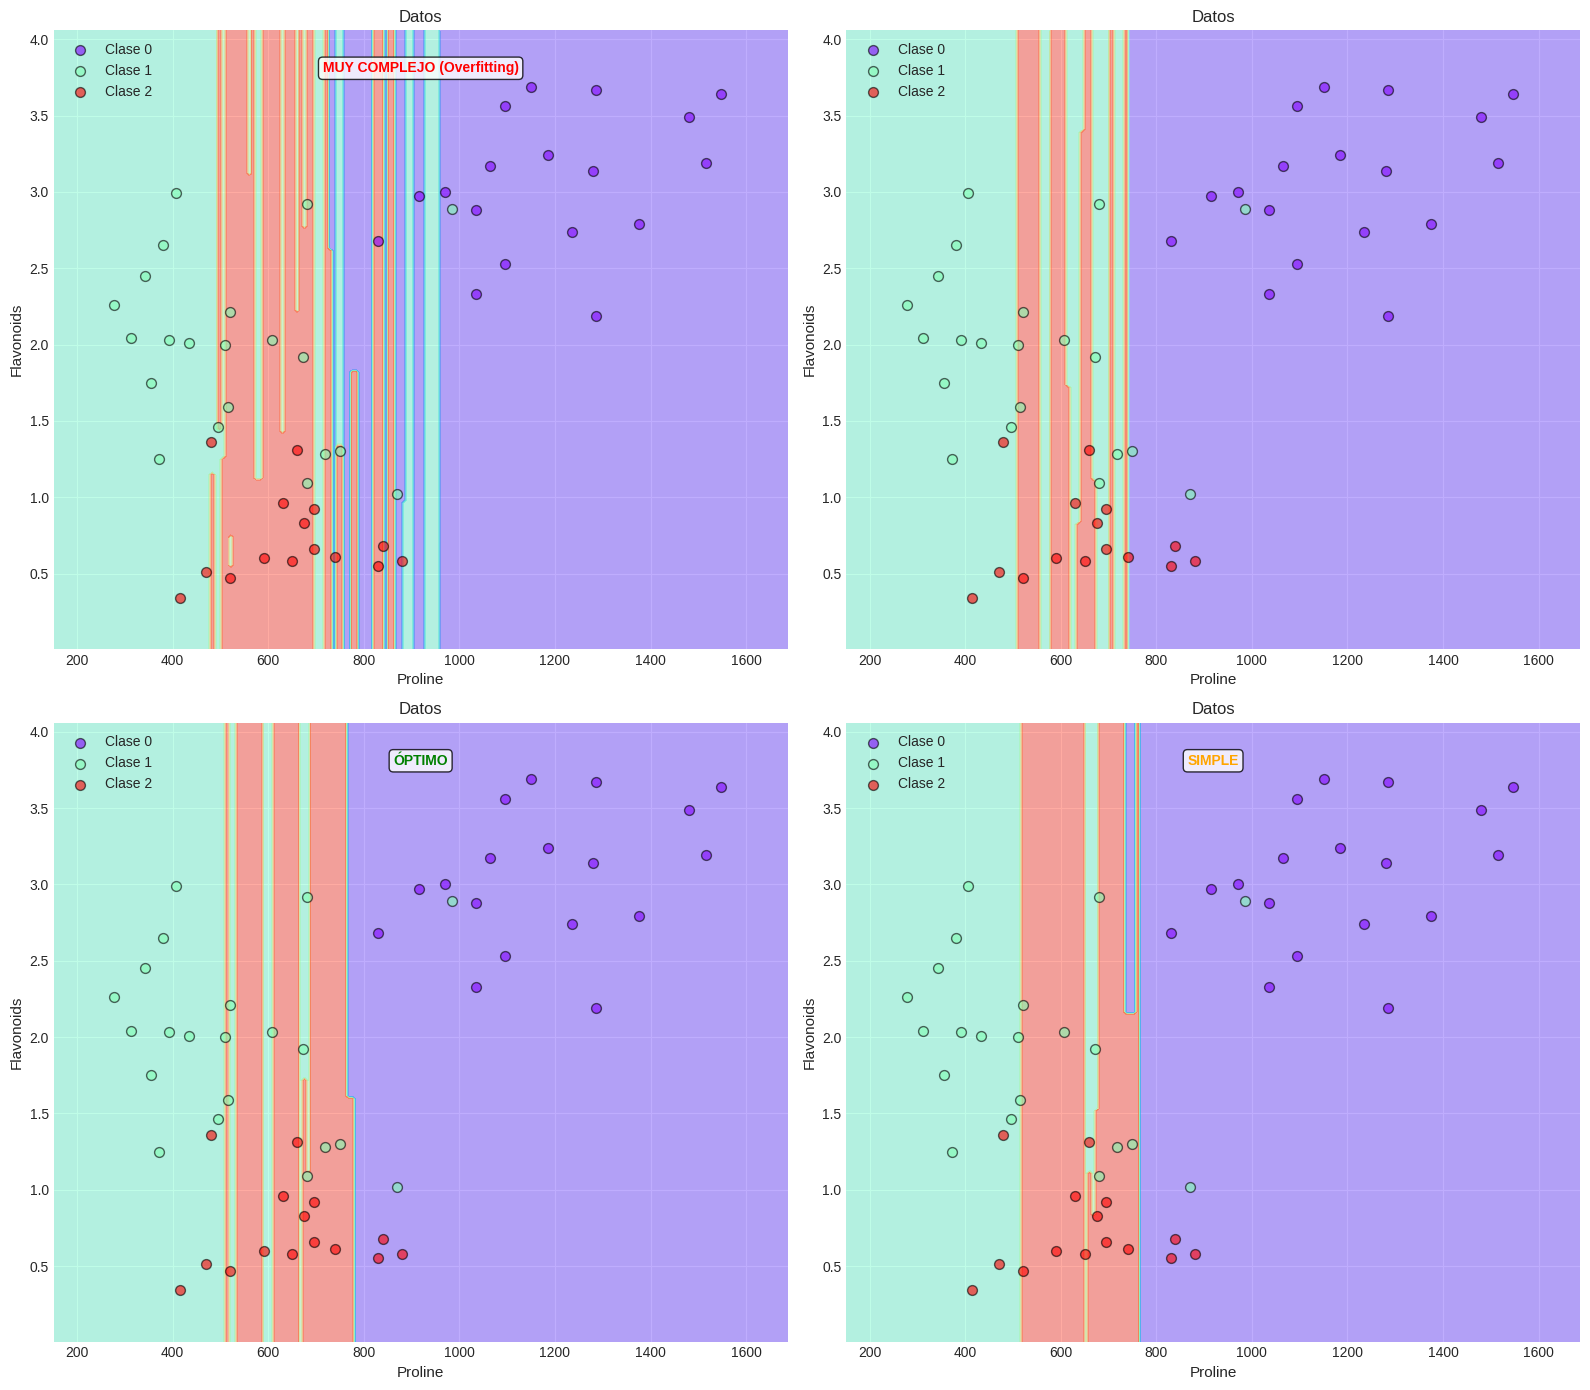


📊 Observaciones:
  • k=1: Fronteras muy irregulares, se ajusta demasiado a puntos individuales
  • k pequeño: Modelo complejo, captura ruido
  • k=20: Balance óptimo entre complejidad y generalización
  • k grande: Fronteras más suaves, puede perder detalles importantes


In [39]:
# Comparar diferentes valores de k
k_compare = [1, 5, optimal_k_2d, 15]

fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.ravel()

for idx, k in enumerate(k_compare):
    plt.sca(axes[idx])
    model = models_2d[k]
    test_acc = (1 - test_errors_2d[k-1]) * 100
    
    plot_decision_region(X_test_2d, gen_pred_fun(model),
                         title=f'k={k} | Accuracy: {test_acc:.2f}%')
    plot_data(X_test_2d, y_test_2d)
    plt.xlabel('Proline', fontsize=11)
    plt.ylabel('Flavonoids', fontsize=11)
    
    # Añadir anotación sobre complejidad
    if k == 1:
        axes[idx].text(0.5, 0.95, 'MUY COMPLEJO (Overfitting)', 
                      transform=axes[idx].transAxes, ha='center', va='top',
                      fontsize=10, fontweight='bold', color='red',
                      bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    elif k == optimal_k_2d:
        axes[idx].text(0.5, 0.95, 'ÓPTIMO', 
                      transform=axes[idx].transAxes, ha='center', va='top',
                      fontsize=10, fontweight='bold', color='green',
                      bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    elif k == 15:
        axes[idx].text(0.5, 0.95, 'SIMPLE', 
                      transform=axes[idx].transAxes, ha='center', va='top',
                      fontsize=10, fontweight='bold', color='orange',
                      bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

print("\n📊 Observaciones:")
print("  • k=1: Fronteras muy irregulares, se ajusta demasiado a puntos individuales")
print("  • k pequeño: Modelo complejo, captura ruido")
print(f"  • k={optimal_k_2d}: Balance óptimo entre complejidad y generalización")
print("  • k grande: Fronteras más suaves, puede perder detalles importantes")

---
## 7. Evaluación Detallada del Modelo Óptimo

### Métricas de Evaluación

Además del accuracy, existen otras métricas importantes para evaluar clasificadores:

1. **Accuracy**: Proporción de predicciones correctas
   - Formula: (TP + TN) / Total
   
2. **Precision**: De las predicciones positivas, cuántas fueron correctas
   - Formula: TP / (TP + FP)
   - Importante cuando el costo de falsos positivos es alto
   
3. **Recall (Sensibilidad)**: De los casos positivos reales, cuántos detectamos
   - Formula: TP / (TP + FN)
   - Importante cuando el costo de falsos negativos es alto
   
4. **F1-Score**: Media armónica de Precision y Recall
   - Formula: 2 * (Precision * Recall) / (Precision + Recall)
   - Balance entre Precision y Recall

**Macro-promedio**: Calcula la métrica para cada clase y luego promedia (todas las clases tienen el mismo peso).

In [40]:
# Obtener predicciones del modelo óptimo
y_pred = optimal_model.predict(X_test_2d)

# Calcular métricas
accuracy = accuracy_score(y_test_2d, y_pred)
error = 1 - accuracy
precision_macro = precision_score(y_test_2d, y_pred, average='macro')
recall_macro = recall_score(y_test_2d, y_pred, average='macro')
f1_macro = f1_score(y_test_2d, y_pred, average='macro')

print("="*70)
print(f"REPORTE DE MÉTRICAS - MODELO KNN (k={optimal_k_2d})")
print("Conjunto de Prueba: Proline vs Flavonoids")
print("="*70)
print(f"\n{'Métrica':<30} {'Valor':<15} {'Porcentaje'}")
print("-"*70)
print(f"{'Accuracy:':<30} {accuracy:.4f} {accuracy*100:>13.2f}%")
print(f"{'Error de Clasificación:':<30} {error:.4f} {error*100:>13.2f}%")
print(f"{'Precision (Macro):':<30} {precision_macro:.4f} {precision_macro*100:>13.2f}%")
print(f"{'Recall (Macro):':<30} {recall_macro:.4f} {recall_macro*100:>13.2f}%")
print(f"{'F1-Score (Macro):':<30} {f1_macro:.4f} {f1_macro*100:>13.2f}%")
print("="*70)

REPORTE DE MÉTRICAS - MODELO KNN (k=20)
Conjunto de Prueba: Proline vs Flavonoids

Métrica                        Valor           Porcentaje
----------------------------------------------------------------------
Accuracy:                      0.7593         75.93%
Error de Clasificación:        0.2407         24.07%
Precision (Macro):             0.7497         74.97%
Recall (Macro):                0.7556         75.56%
F1-Score (Macro):              0.7452         74.52%


### Matriz de Confusión

La matriz de confusión muestra cómo se distribuyen las predicciones del modelo:
- **Diagonal principal**: Predicciones correctas
- **Fuera de la diagonal**: Errores de clasificación

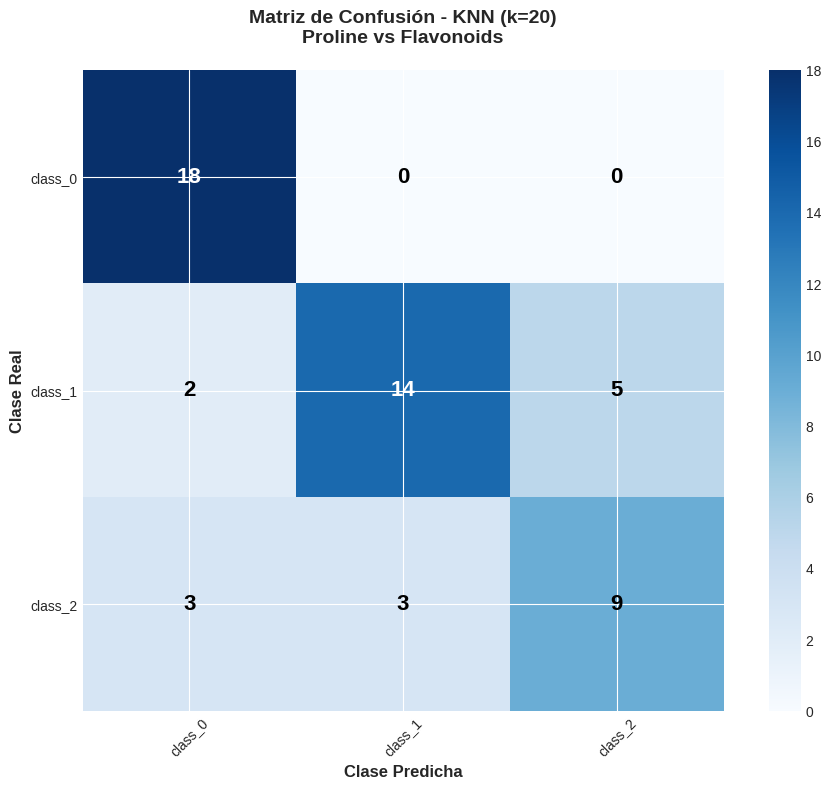


Matriz de Confusión (formato numérico):
                   Predicho
                   class_0      class_1      class_2     
Real class_0      18           0            0           
     class_1      2            14           5           
     class_2      3            3            9           


In [41]:
# Calcular matriz de confusión
cm = confusion_matrix(y_test_2d, y_pred)

# Visualizar matriz de confusión
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(f'Matriz de Confusión - KNN (k={optimal_k_2d})\nProline vs Flavonoids', 
          fontsize=14, fontweight='bold', pad=20)
plt.colorbar()

# Añadir etiquetas
tick_marks = np.arange(len(wine_data.target_names))
plt.xticks(tick_marks, wine_data.target_names, rotation=45)
plt.yticks(tick_marks, wine_data.target_names)

# Añadir valores en cada celda
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black",
                fontsize=16, fontweight='bold')

plt.ylabel('Clase Real', fontsize=12, fontweight='bold')
plt.xlabel('Clase Predicha', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nMatriz de Confusión (formato numérico):")
print("                   Predicho")
print(f"                   {wine_data.target_names[0]:<12} {wine_data.target_names[1]:<12} {wine_data.target_names[2]:<12}")
for i, clase in enumerate(wine_data.target_names):
    if i == 0:
        print(f"Real {clase:<12} {cm[i, 0]:<12} {cm[i, 1]:<12} {cm[i, 2]:<12}")
    else:
        print(f"     {clase:<12} {cm[i, 0]:<12} {cm[i, 1]:<12} {cm[i, 2]:<12}")

### Reporte de Clasificación Detallado

Scikit-learn nos proporciona un reporte completo con métricas por clase:

In [44]:
# Reporte de clasificación completo
print("\n" + "="*70)
print("REPORTE DE CLASIFICACIÓN DETALLADO")
print("="*70)
print(classification_report(y_test_2d, y_pred, 
                           target_names=wine_data.target_names,
                           digits=4))

print("\n📊 Interpretación del reporte:")
print("  • precision: De las predicciones de cada clase, cuántas fueron correctas")
print("  • recall: De los ejemplos reales de cada clase, cuántos se detectaron")
print("  • f1-score: Balance entre precision y recall")
print("  • support: Número de muestras reales de cada clase en el conjunto de prueba")
print("  • macro avg: Promedio simple de las métricas (todas las clases pesan igual)")
print("  • weighted avg: Promedio ponderado por el número de muestras de cada clase")


REPORTE DE CLASIFICACIÓN DETALLADO
              precision    recall  f1-score   support

     class_0     0.7826    1.0000    0.8780        18
     class_1     0.8235    0.6667    0.7368        21
     class_2     0.6429    0.6000    0.6207        15

    accuracy                         0.7593        54
   macro avg     0.7497    0.7556    0.7452        54
weighted avg     0.7597    0.7593    0.7516        54


📊 Interpretación del reporte:
  • precision: De las predicciones de cada clase, cuántas fueron correctas
  • recall: De los ejemplos reales de cada clase, cuántos se detectaron
  • f1-score: Balance entre precision y recall
  • support: Número de muestras reales de cada clase en el conjunto de prueba
  • macro avg: Promedio simple de las métricas (todas las clases pesan igual)
  • weighted avg: Promedio ponderado por el número de muestras de cada clase


---
## 8. Resumen y Conclusiones

### Resumen de Resultados

In [45]:
print("="*80)
print("RESUMEN FINAL DEL TALLER")
print("="*80)

print("\n1. DATASET")
print("-" * 80)
print(f"   • Nombre: Wine Dataset")
print(f"   • Total de muestras: {len(y)}")
print(f"   • Características totales: {X.shape[1]}")
print(f"   • Clases: {len(np.unique(y))} ({', '.join(wine_data.target_names)})")
print(f"   • Partición: 70% entrenamiento ({len(y_train)} muestras), "
      f"30% prueba ({len(y_test)} muestras)")

print("\n2. ANÁLISIS CON TODAS LAS CARACTERÍSTICAS")
print("-" * 80)
print(f"   • k óptimo: {optimal_k}")
print(f"   • Accuracy de prueba: {(1-min_test_error)*100:.2f}%")
print(f"   • Error de prueba: {min_test_error*100:.2f}%")

print("\n3. ANÁLISIS CON PROLINE VS FLAVONOIDS")
print("-" * 80)
print(f"   • k óptimo: {optimal_k_2d}")
print(f"   • Accuracy de prueba: {accuracy*100:.2f}%")
print(f"   • Error de clasificación: {error*100:.2f}%")
print(f"   • Precision (macro): {precision_macro*100:.2f}%")
print(f"   • Recall (macro): {recall_macro*100:.2f}%")
print(f"   • F1-Score (macro): {f1_macro*100:.2f}%")

print("\n4. CONCLUSIONES SOBRE OVERFITTING Y UNDERFITTING")
print("-" * 80)
print("   • Con k=1:")
print("     - Modelo muy complejo (overfitting)")
print("     - Aprende el ruido de los datos")
print("     - Bajo error de entrenamiento, alto error de prueba")
print("     - Fronteras de decisión muy irregulares")

print(f"\n   • Con k={optimal_k_2d} (óptimo):")
print("     - Balance entre complejidad y generalización")
print("     - Minimiza el error de prueba")
print("     - Captura patrones relevantes sin ajustarse al ruido")

print("\n   • Con k grande (ej. k=15-20):")
print("     - Modelo simple (underfitting)")
print("     - No captura suficiente complejidad de los datos")
print("     - Error de entrenamiento y prueba altos")
print("     - Fronteras de decisión muy suaves")

print("\n5. LECCIONES APRENDIDAS")
print("-" * 80)
print("   ✓ La complejidad del modelo debe ajustarse a la complejidad de los datos")
print("   ✓ Es fundamental usar conjuntos de entrenamiento y prueba separados")
print("   ✓ La estratificación mantiene la distribución de clases en las particiones")
print("   ✓ El análisis de curvas de error ayuda a identificar el modelo óptimo")
print("   ✓ Visualizar superficies de decisión ayuda a entender el comportamiento del modelo")
print("   ✓ Múltiples métricas (Accuracy, Precision, Recall, F1) dan una visión completa")

print("\n" + "="*80)
print("FIN DEL TALLER")
print("="*80)

RESUMEN FINAL DEL TALLER

1. DATASET
--------------------------------------------------------------------------------
   • Nombre: Wine Dataset
   • Total de muestras: 178
   • Características totales: 13
   • Clases: 3 (class_0, class_1, class_2)
   • Partición: 70% entrenamiento (124 muestras), 30% prueba (54 muestras)

2. ANÁLISIS CON TODAS LAS CARACTERÍSTICAS
--------------------------------------------------------------------------------
   • k óptimo: 11
   • Accuracy de prueba: 75.93%
   • Error de prueba: 24.07%

3. ANÁLISIS CON PROLINE VS FLAVONOIDS
--------------------------------------------------------------------------------
   • k óptimo: 20
   • Accuracy de prueba: 75.93%
   • Error de clasificación: 24.07%
   • Precision (macro): 74.97%
   • Recall (macro): 75.56%
   • F1-Score (macro): 74.52%

4. CONCLUSIONES SOBRE OVERFITTING Y UNDERFITTING
--------------------------------------------------------------------------------
   • Con k=1:
     - Modelo muy complejo (overfi

---
## Conceptos Clave para Recordar

### 1. K-Nearest Neighbors (KNN)
- Algoritmo de clasificación no paramétrico
- Clasifica basándose en la "votación por mayoría" de los k vecinos más cercanos
- La elección de k determina la complejidad del modelo

### 2. Overfitting (Sobreajuste)
- Ocurre cuando el modelo es demasiado complejo
- Aprende el ruido y detalles específicos del conjunto de entrenamiento
- Bajo error de entrenamiento pero alto error de prueba
- En KNN: k pequeño (ej. k=1)

### 3. Underfitting (Subajuste)
- Ocurre cuando el modelo es demasiado simple
- No captura los patrones importantes de los datos
- Alto error tanto en entrenamiento como en prueba
- En KNN: k muy grande

### 4. Trade-off Sesgo-Varianza
- **Sesgo alto** (underfitting): Modelo simple, asumpciones incorrectas
- **Varianza alta** (overfitting): Modelo complejo, sensible al ruido
- **Objetivo**: Encontrar el balance óptimo

### 5. Evaluación del Modelo
- **Conjunto de entrenamiento**: Para aprender patrones
- **Conjunto de prueba**: Para medir generalización
- **Estratificación**: Mantener distribución de clases
- **Múltiples métricas**: Accuracy, Precision, Recall, F1-Score

---

## Referencias y Recursos

- [Scikit-learn Documentation: KNN](https://scikit-learn.org/stable/modules/neighbors.html)
- [Scikit-learn Documentation: Wine Dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html)
- [Understanding the Bias-Variance Tradeoff](http://scott.fortmann-roe.com/docs/BiasVariance.html)